In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [263]:
class Emprunteur_agent():

    def __init__(self, taux, montant_restant, duree_restante, proba_default, date_emprunt, notation=None, a_fait_defaut=False):
        self.id = np.random.randint(0, 10000000)
        self.taux = taux
        self.montant_initial = montant_restant # montant initial emprunté
        self.montant_restant = montant_restant # montant restant dû
        self.mensualite = montant_restant * (taux / 12) / (1 - (1 + taux / 12) ** -duree_restante)
        self.duree_restante = duree_restante # durée restante
        self.duree_totale = duree_restante # durée totale
    
        self.proba_default = proba_default # probabilité de défaut
        self.date_emprunt = date_emprunt # date de l'emprunt (pour calculer la durée restante)

        self.a_fait_defaut = a_fait_defaut

        self.notation = notation # notation de l'emprunteur

    def __str__(self):
        if self.a_fait_defaut != True:
            return f"Emprunteur N°{self.id} a {self.montant_restant}€ restant à rembourser, avec une mensualité de {self.mensualite:.2f}€ et un taux de {self.taux * 100}%, (risque de défaut de {self.proba_default * 100}%)"
        else:
            return f"L'emprunteur N°{self.id} a fait défaut (montant restant : {self.montant_initial}€)"
    
    def remboursement_mensuel(self):
        self.montant_restant -= self.mensualite
        self.duree_restante -= 1

    def taux_effectif(self):
        s = 0
        for _ in range(self.duree_totale):
            s += self.mensualite
        return (s - self.montant_initial) / (self.montant_initial * self.duree_totale)


class Portfolio():
    def __init__(self, liste_emprunteurs, liquidite):
        self.liste_emprunteurs = liste_emprunteurs
        self.liquidite = -liquidite
        for e in self.liste_emprunteurs:
            self.liquidite -= e.montant_initial
    
    def mensualite_totale(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.mensualite
        return cumul
    
    def montant_initial(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.montant_initial
        return cumul

    def montant_total(self):
        cumul = 0
        for emprunteur in self.liste_emprunteurs:
            cumul += emprunteur.montant_restant
        return cumul
    
    def montant_remboursement_total(self, emprunteur):
        cumul = 0
        for _ in range(emprunteur.duree_restante):
            cumul += emprunteur.mensualite
            emprunteur.remboursement_mensuel()
        return cumul   
    
    def default(self, e):
        if np.random.rand() < e.proba_default:
            e.a_fait_defaut = True
            e.montant_restant = 0
            e.duree_restante = 0

    def amortissement_emprunteur(self, e):
        cumul = 0
        for _ in range(e.duree_restante):
            cumul += e.mensualite
            self.default(e)
            if e.a_fait_defaut:
                break
            else:
                self.liquidite += e.mensualite
                e.remboursement_mensuel()
        return cumul
        

class Strategy():

    def __init__(self, nb_emprunt, montant_a_investir=1000, date_emprunt="2023-01-01", taux=0.09, proba_defaut=0.06):
        self.nb_emprunt = nb_emprunt # nombre d'emprunts à investir 
        self.montant_a_investir = montant_a_investir # montant à investir
        self.date_emprunt = date_emprunt # date de l'emprunt
        self.amortissements = {} # dictionnaire des amortissements des emprunteurs
        self.portfolio = None # portefeuille d'emprunteurs 
        self.taux = taux # taux d'intérêt moyen
        self.proba_defaut = proba_defaut # probabilité de défaut moyenne

        self.notations_dict = {} # dictionnaire des notations des emprunteurs
        self.ponderation_dict = {} # dictionnaire des pondérations des notations
        self.defaut_notations_dict = {} # dictionnaire des probabilités de défaut par notation
        self.taux_notations_dict = {} # dictionnaire des taux de défaut par notation

    
    def notations(self):
        notation_dict = {
            'tres_fiable': ['AAA'],
            'fiable': ['AA', 'A,', 'BBB'],
            'moyennement_fiable': [ 'BB', 'B', 'CCC'],
            'peu_fiable': [ 'CC', 'C', 'D']
        }
        self.notations_dict = notation_dict

    def ponderation(self):
        ponderation_dict = {
            'tres_fiable': 0.1,
            'fiable': 0.2,
            'moyennement_fiable': 0.4,
            'peu_fiable': 0.3
        }
        self.ponderation_dict = ponderation_dict

    def defaut_notations(self):
        defaut_dict = {
            'tres_fiable': 0.01,
            'fiable': 0.4,
            'moyennement_fiable': 0.07,
            'peu_fiable': 0.12
        }
        self.defaut_notations_dict = defaut_dict

    def taux_notation(self):
        taux_dict = {
            'tres_fiable': 0.08,
            'fiable': 0.095,
            'moyennement_fiable': 0.105,
            'peu_fiable': 0.12
        }
        self.taux_notations_dict = taux_dict
    
    def merge_notation_ponderation(self):
        # Create a copy of the notations dictionary
        if self.notations_dict == {} or self.ponderation_dict == {} or self.defaut_notations_dict == {} or self.taux_notations_dict == {}:
            self.notations()
            self.ponderation()
            self.defaut_notations()
            self.taux_notation()

        merged_dict = self.notations_dict.copy()
        # Update the copy with the ponderation dictionary
        for key, value in self.ponderation_dict.items():
            merged_dict[key].append(value)
        # Update the copy with the default dictionary
        for key, value in self.defaut_notations_dict.items():
            merged_dict[key].append(value)
        # Update the copy with the taux dictionary
        for key, value in self.taux_notations_dict.items():
            merged_dict[key].append(value)
        return merged_dict

    def investissement_uniforme(self):
        montant_par_emprunt = self.montant_a_investir / self.nb_emprunt
        liste_emprunteurs = []
        for _ in range(self.nb_emprunt):
            taux = self.taux
            montant_restant = montant_par_emprunt
            duree_restante = np.random.randint(21, 23)
            # defaut = self.proba_defaut / duree_restante
            defaut = self.proba_defaut / duree_restante
            liste_emprunteurs.append(Emprunteur_agent(taux, montant_restant, duree_restante, defaut, self.date_emprunt))
            self.montant_a_investir -= montant_restant
        self.portfolio = Portfolio(liste_emprunteurs, self.montant_a_investir)

    def investissement_random(self):
        montant_par_emprunt = self.montant_a_investir / self.nb_emprunt
        liste_emprunteurs = []
        for _ in range(self.nb_emprunt):
            taux = np.random.uniform(self.taux * 0.9,self.taux * 1.1)
            montant_restant = np.random.randint(montant_par_emprunt, montant_par_emprunt+1)
            duree_restante = np.random.randint(12, 36)
            defaut = round(np.random.uniform(self.proba_defaut * 0.9, 1.1 * self.proba_defaut), 2) / duree_restante
            liste_emprunteurs.append(Emprunteur_agent(taux, montant_restant, duree_restante, defaut, self.date_emprunt))
            self.montant_a_investir -= montant_restant
        self.portfolio = Portfolio(liste_emprunteurs, self.montant_a_investir) 

    def investissement_notation(self):
        """
        Allocate the portfolio based on the notations and their respective weights
        """
        liste_emprunteurs = []
        notation_ponderation = self.merge_notation_ponderation()
        montant_total = self.montant_a_investir
        for notation, values in notation_ponderation.items():
            # print(f"Notation {notation} : {values}")
            montant_par_notation = montant_total * values[-3]
            print(f"Montant par notation {notation} : {montant_par_notation:.2f}")
            for _ in range(int(self.nb_emprunt*values[-3])):
                taux = values[-1]
                montant_restant = montant_par_notation / (self.nb_emprunt*values[-3])
                print(f"Montant restant : {montant_restant:.2f}")
                duree_restante = np.random.randint(12, 36)
                defaut = values[-2] / duree_restante
                liste_emprunteurs.append(Emprunteur_agent(taux, montant_restant, duree_restante, defaut, self.date_emprunt))
                self.montant_a_investir -= montant_restant
        self.portfolio = Portfolio(liste_emprunteurs, self.montant_a_investir)

    def Liquidite(self):
        for e in self.portfolio.liste_emprunteurs:
            self.amortissements[e.id] = self.portfolio.amortissement_emprunteur(e)
        return self.portfolio.liquidite


class Backtest:

    def __init__(self, nb_emprunt, montant_a_investir, type_investissement, date_emprunt, 
                 taux=0.09, proba_defaut=0.06, 
                 ponderation_notation=None, taux_notation=None, proba_defaut_notation=None,  
                 nb_essais=1000):

        # Parameters of the backtest
        self.nb_emprunt = nb_emprunt
        self.montant_a_investir = montant_a_investir
        self.date_emprunt = date_emprunt

        # Parameters for the notation-based investment
        self.ponderation_notation = ponderation_notation
        self.taux_notation = taux_notation
        self.proba_defaut_notation = proba_defaut_notation

        # Parameters for the backtest
        self.taux = taux
        self.proba_defaut = proba_defaut
        self.nb_essais = nb_essais

        # Results of the backtest
        self.final_liquidite = None
        self.results = None
        self.matrice_taux_default = None

        # Type of investment strategy (uniform, random, notation)
        self.type_investissement = type_investissement

        # Flags to check if the backtest has been run and if the results have been calculated
        self.is_backtested = False
        self.is_results_calculated = False
        self.is_matrice_taux_defaut_calculated = False


    def backtest(self):
        self.results = {}

        final_liquidite = {}
        if self.type_investissement == "uniforme":
            for n in self.nb_emprunt:
                self.results[n] = {}
                final_liquidite[n] = []
                for _ in range(self.nb_essais):
                    s = Strategy(n, self.montant_a_investir, self.date_emprunt, self.taux, self.proba_defaut)
                    s.investissement_uniforme()
                    final_liquidite[n].append(s.Liquidite())

        elif self.type_investissement == "random":
            for n in self.nb_emprunt:
                self.results[n] = {}
                final_liquidite[n] = []
                for _ in range(self.nb_essais):
                    s = Strategy(n, self.montant_a_investir, self.date_emprunt, self.taux, self.proba_defaut)
                    s.investissement_random()
                    final_liquidite[n].append(s.Liquidite())
        
        elif self.type_investissement == "notation":
            for n in self.nb_emprunt:
                self.results[n] = {}
                final_liquidite[n] = []
                for _ in range(self.nb_essais):
                    s = Strategy(n, self.montant_a_investir, self.date_emprunt, self.taux, self.proba_defaut)
                    s.ponderation_dict = self.ponderation_notation
                    s.taux_notation_dict = self.taux_notation
                    s.defaut_notations_dict = self.proba_defaut_notation
                    s.investissement_notation()
                    final_liquidite[n].append(s.Liquidite())

        else:
            raise ValueError("Type d'investissement non reconnu")


        self.final_liquidite = pd.DataFrame(final_liquidite, columns=self.nb_emprunt, index=range(self.nb_essais))
        self.final_liquidite /= self.montant_a_investir # Normalize results by the amount invested to compare strategies with different amounts invested
        self.is_backtested = True

    def calculate_results(self, pt_bin=0.001, taux_sans_risque=0.03):
        if not self.is_results_calculated:
            for n in self.nb_emprunt:

                self.results[n]['VaR 95%'] = self.final_liquidite[n].quantile(0.05)
                self.results[n]['ES 95%'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['VaR 95%']].mean()
                self.results[n]['VaR 99%'] = self.final_liquidite[n].quantile(0.01)
                self.results[n]['ES 99%'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['VaR 99%']].mean()
                self.results[n]['Mean'] = self.final_liquidite[n].mean()
                self.results[n]['Std'] = self.final_liquidite[n].std()
                self.results[n]['Max'] = self.final_liquidite[n].max()
                self.results[n]['Min'] = self.final_liquidite[n].min()
                self.results[n]['Median'] = self.final_liquidite[n].median()

                binned = pd.DataFrame(pd.cut(self.final_liquidite[n], 
                                             bins=np.arange(-self.montant_a_investir, 1.25*self.montant_a_investir, pt_bin), 
                                             labels=False, include_lowest=True) * pt_bin, 
                                        columns=[n])
                
                binned -= self.montant_a_investir
                self.results[n]['Mode'] = binned.mode()[n][0]
                # self.results[n]['Mode'] = self.final_liquidite[n].mode()

                self.results[n]['Expected Loss'] = self.final_liquidite[n][self.final_liquidite[n] < 0].mean()
                self.results[n]['Expected Gain'] = self.final_liquidite[n][self.final_liquidite[n] > 0].mean()
                self.results[n]['Lower Semi Deviation'] = self.final_liquidite[n][self.final_liquidite[n] < self.results[n]['Mean']].std()
                self.results[n]['Upper Semi Deviation'] = self.final_liquidite[n][self.final_liquidite[n] > self.results[n]['Mean']].std()

                self.results[n]['Sortino Ratio'] = self.results[n]['Mean'] / self.results[n]['Lower Semi Deviation']
                self.results[n]['Sharpe Ratio'] = (self.results[n]['Mean'] - taux_sans_risque) / self.results[n]['Std']
                self.results[n]['Information Ratio'] = self.results[n]['Mean'] / self.results[n]['ES 95%']
                self.results[n]['Calmar Ratio'] = self.results[n]['Mean'] / self.final_liquidite[n].max()
                self.results[n]['Sterling Ratio'] = self.results[n]['Mean'] / self.results[n]['Lower Semi Deviation']
                self.results[n]['Skewness'] = self.final_liquidite[n].skew()
                self.results[n]['Kurtosis'] = self.final_liquidite[n].kurtosis()

                self.results[n] = pd.DataFrame(self.results[n], index=[n])
            # Combine all results into a single DataFrame
            self.results = pd.concat(self.results, axis=0).reset_index(drop=True).T
            self.results = self.results.round(3)
            self.results.columns = self.nb_emprunt
            self.is_results_calculated = True
        else:
            print("Results already calculated")

    def compute_matrice_taux_default(self, bornes_taux, bornes_defaut, resolution=0.01):
        
        taux_liste = np.arange(bornes_taux[0], bornes_taux[1], resolution)
        defaut_liste = np.arange(bornes_defaut[0], bornes_defaut[1], resolution)

        d = {}
        for defaut in tqdm(defaut_liste):
            t = {}
            for taux in taux_liste:
                b = Backtest(nb_emprunt=self.nb_emprunt,
                                montant_a_investir=self.montant_a_investir,
                                date_emprunt=self.date_emprunt,
                                taux=taux,
                                proba_defaut=defaut,
                                nb_essais=self.nb_essais)
                
                b.backtest()
                b.calculate_results()
                t[taux] = b.results[b.nb_emprunt[0]]['Mode']

                del b
            d[defaut] = t
            
        self.matrice_taux_default = pd.DataFrame(d, index=taux_liste).T 
        self.is_matrice_taux_defaut_calculated = True
    
    def plot_matrice_taux_default(self):
        if self.is_matrice_taux_defaut_calculated:
            plt.figure(figsize=(15, 8))
            sns.heatmap(self.matrice_taux_default, cmap="coolwarm", annot=True)
            plt.title("Matrice des Gains en fonction du taux d'intérêt et du taux de défaut")
            plt.xlabel("Taux d'intérêt")
            plt.ylabel("Taux de défaut")
            plt.show()
        else:
            print("Matrice des gains non calculée, veuillez lancer la méthode compute_matrice_taux_default")

    def plot_optimal_taux_default(self):
        if self.is_matrice_taux_defaut_calculated:
            plt.figure(figsize=(15, 5))
            sns.heatmap(self.matrice_taux_default.idxmin(axis=1).to_frame(), cmap="coolwarm", annot=True)
            plt.title("Gain optimal en fonction du taux d'intérêt et du taux de défaut")
            plt.xlabel("Taux d'intérêt")
            plt.ylabel("Taux de défaut")
            plt.show()
        else:
            print("Matrice des gains non calculée, veuillez lancer la méthode compute_matrice_taux_default")

            
    def plot_results(self):
        if self.is_results_calculated:
            for n in self.nb_emprunt:
                plt.figure(figsize=(15, 5))
                sns.histplot(self.final_liquidite[n], kde=True, label=f"{n} emprunts", color=[np.random.rand(), np.random.rand(), np.random.rand()])
                plt.title("Distribution du gain final")
                plt.xlabel("Gain/Perte (€)")
                plt.ylabel("Nb d'occurences")
                plt.legend()
                plt.show()
        else:
            print("Matrice des gains non calculée, veuillez lancer la méthode compute_matrice_taux_default")


In [264]:
b = Backtest(nb_emprunt=[10*i for i in range(1, 11)],
                montant_a_investir=1000,
                date_emprunt="2021-01-01",
                type_investissement="notation",
                ponderation_notation={'tres_fiable': 0.0, 'fiable': 1.0, 'moyennement_fiable': 0.0, 'peu_fiable': 0.0},
                taux_notation={'tres_fiable': 0.04, 'fiable': 0.1, 'moyennement_fiable': 0.1, 'peu_fiable': 0.15},
                proba_defaut_notation={'tres_fiable': 0.01, 'fiable': 0.04, 'moyennement_fiable': 0.07, 'peu_fiable': 0.12},
                nb_essais=5)

b.backtest()
b.calculate_results()
b.results

Montant par notation tres_fiable : 100.00
Montant restant : 100.00
Montant par notation fiable : 200.00
Montant restant : 100.00
Montant restant : 100.00
Montant par notation moyennement_fiable : 400.00
Montant restant : 100.00
Montant restant : 100.00
Montant restant : 100.00
Montant restant : 100.00
Montant par notation peu_fiable : 300.00
Montant restant : 100.00
Montant restant : 100.00
Montant restant : 100.00
Montant par notation tres_fiable : 100.00
Montant restant : 100.00
Montant par notation fiable : 200.00
Montant restant : 100.00
Montant restant : 100.00
Montant par notation moyennement_fiable : 400.00
Montant restant : 100.00
Montant restant : 100.00
Montant restant : 100.00
Montant restant : 100.00
Montant par notation peu_fiable : 300.00
Montant restant : 100.00
Montant restant : 100.00
Montant restant : 100.00
Montant par notation tres_fiable : 100.00
Montant restant : 100.00
Montant par notation fiable : 200.00
Montant restant : 100.00
Montant restant : 100.00
Montant 

,10,20,30,40,50,60,70,80,90,100
VaR 95%,-0.009,-0.055,0.025,0.004,0.010,-0.004,0.032,0.000,0.007,0.013
ES 95%,-0.013,-0.074,0.019,-0.005,0.007,-0.008,0.027,-0.002,0.006,0.006
VaR 99%,-0.012,-0.071,0.020,-0.003,0.007,-0.007,0.028,-0.002,0.006,0.007
ES 99%,-0.013,-0.074,0.019,-0.005,0.007,-0.008,0.027,-0.002,0.006,0.006
Mean,0.025,0.019,0.073,0.049,0.037,0.031,0.056,0.035,0.027,0.048
Std,0.037,0.054,0.038,0.033,0.023,0.031,0.022,0.033,0.021,0.028
Max,0.079,0.060,0.106,0.077,0.069,0.072,0.086,0.082,0.051,0.084
Min,-0.013,-0.074,0.019,-0.005,0.007,-0.008,0.027,-0.002,0.006,0.006
Median,0.008,0.041,0.084,0.066,0.041,0.033,0.053,0.041,0.025,0.049
Mode,-0.013,-0.075,0.018,-0.006,0.006,-0.009,0.027,-0.003,0.006,0.005


In [267]:
s = Strategy(nb_emprunt=10, montant_a_investir=100)


s.investissement_notation()
s.notations_dict = {'tres_fiable': ['AAA'], 'fiable': ['AA', 'A,', 'BBB'], 'moyennement_fiable': [ 'BB', 'B', 'CCC'], 'peu_fiable': [ 'CC', 'C', 'D']}
s.ponderation_dict = {'tres_fiable': 0.25, 'fiable': 0.25, 'moyennement_fiable': 0.25, 'peu_fiable': 0.25}
s.taux_notation_dict = {'tres_fiable': 0.04, 'fiable': 0.08, 'moyennement_fiable': 0.1, 'peu_fiable': 0.15}
s.defaut_notations_dict = {'tres_fiable': 0.0, 'fiable': 0.0, 'moyennement_fiable': 0.0, 'peu_fiable': 0.0}

s.investissement_notation()
s.Liquidite()

Montant par notation tres_fiable : 10.00
Montant restant : 10.00
Montant par notation fiable : 20.00
Montant restant : 10.00
Montant restant : 10.00
Montant par notation moyennement_fiable : 40.00
Montant restant : 10.00
Montant restant : 10.00
Montant restant : 10.00
Montant restant : 10.00
Montant par notation peu_fiable : 30.00
Montant restant : 10.00
Montant restant : 10.00
Montant restant : 10.00
Montant par notation tres_fiable : 0.00
Montant restant : 0.00
Montant restant : 0.00
Montant par notation fiable : 0.00
Montant restant : 0.00
Montant restant : 0.00
Montant par notation moyennement_fiable : 0.00
Montant restant : 0.00
Montant restant : 0.00
Montant par notation peu_fiable : 0.00
Montant restant : 0.00
Montant restant : 0.00


0.0

In [8]:
matrice_taux_default_e150_nb1500 = pd.read_excel("matrice_taux_default_e150_nb1500.xlsx", index_col=0)

,0.010,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,...,0.150,0.151,0.152,0.153,0.154,0.155,0.156,0.157,0.158,0.159
0.010,0.005,0.005,0.006,0.007,0.007,0.008,0.008,0.009,0.009,0.010,...,0.083,0.083,0.084,0.084,0.085,0.085,0.086,0.087,0.087,0.088
0.011,0.005,0.005,0.006,0.007,0.007,0.008,0.008,0.009,0.009,0.010,...,0.083,0.083,0.084,0.084,0.085,0.085,0.086,0.087,0.087,0.088
0.012,0.005,0.005,0.006,0.007,0.007,0.008,0.008,0.009,0.009,0.010,...,0.083,0.083,0.084,0.084,0.085,0.085,0.086,0.087,0.087,0.088
0.013,0.005,0.005,0.006,0.007,0.007,0.008,0.008,0.009,0.009,0.010,...,0.083,0.083,0.084,0.084,0.085,0.085,0.086,0.087,0.087,0.088
0.014,0.005,0.005,0.006,0.007,0.007,0.008,0.008,0.009,0.009,0.010,...,0.083,0.083,0.084,0.084,0.085,0.085,0.086,0.087,0.087,0.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.145,-0.068,-0.071,-0.071,-0.064,-0.070,-0.063,-0.069,-0.061,-0.063,-0.063,...,0.004,-0.001,-0.005,0.004,-0.003,0.002,0.008,-0.006,0.007,0.004
0.146,-0.082,-0.071,-0.069,-0.071,-0.070,-0.070,-0.073,-0.066,-0.066,-0.068,...,-0.009,-0.001,0.004,0.005,0.020,-0.001,-0.006,0.006,0.006,0.002
0.147,-0.074,-0.069,-0.067,-0.061,-0.071,-0.065,-0.065,-0.061,-0.061,-0.067,...,0.009,0.006,-0.005,0.010,-0.001,-0.007,0.005,0.015,0.003,0.010
0.148,-0.072,-0.078,-0.068,-0.078,-0.070,-0.063,-0.075,-0.071,-0.072,-0.073,...,0.004,-0.002,-0.008,0.007,0.003,-0.001,-0.008,0.000,-0.002,-0.004


In [19]:
# b = Backtest(nb_emprunt=[150], montant_a_investir=1000, date_emprunt="2023-01-01", taux=0.1, proba_defaut=0.06, nb_essais=1000)
# b.backtest()
# b.calculate_results()
# b.compute_matrice_taux_default(bornes_taux=[0.01, 0.16], bornes_defaut=[0.01, 0.15], resolution=0.001)

# b.matrice_taux_default.to_excel("matrice_taux_default_e150_nb1500.xlsx")

# b.plot_matrice_taux_default()
# b.plot_optimal_taux_default()


In [15]:
import plotly.graph_objects as go

# Assuming b.matrice_taux_default is a DataFrame
matrice_taux_default = matrice_taux_default_e150_nb1500

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(z=matrice_taux_default.values, x=matrice_taux_default.columns, y=matrice_taux_default.index, colorscale='Viridis')])
fig.update_layout(title='Gain/Perte en fonction du taux d\'intérêt et du taux de défaut pour un pf de 150 emprunteurs', autosize=False, 
                    width=1000, height=800, margin=dict(l=65, r=50, b=65, t=90))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='Taux', yaxis_title='Proba Default', zaxis_title='Gain/Perte (%)'))

# Show the interactive plot
fig.show()


In [21]:
b = Backtest(nb_emprunt=[300], montant_a_investir=1000, date_emprunt="2023-01-01", taux=0.1, proba_defaut=0.06, nb_essais=750)
b.backtest()
b.calculate_results()
b.compute_matrice_taux_default(bornes_taux=[0.01, 0.16], bornes_defaut=[0.01, 0.15], resolution=0.005)

b.matrice_taux_default.to_excel("matrice_taux_default_e300_nb1500.xlsx")



100%|██████████| 28/28 [52:29<00:00, 112.47s/it]


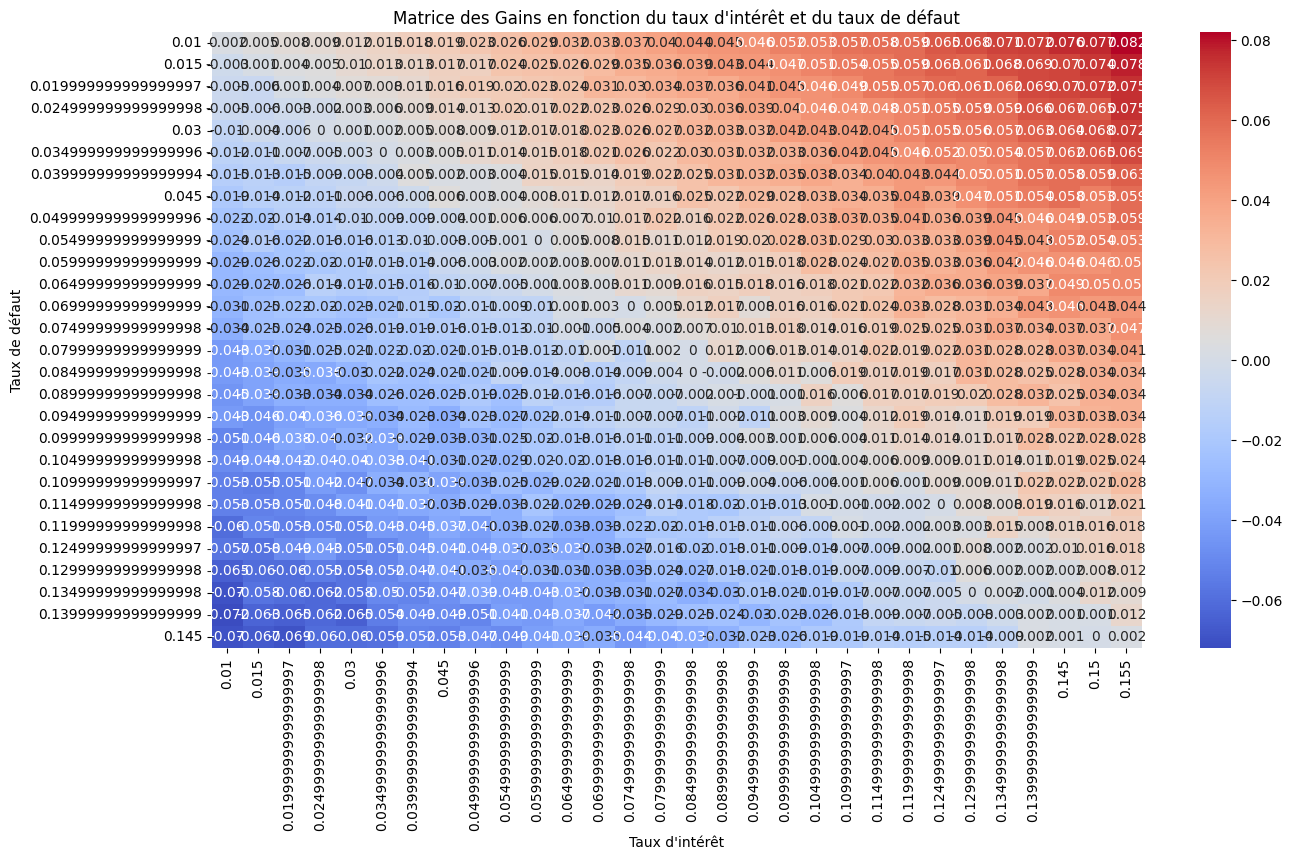

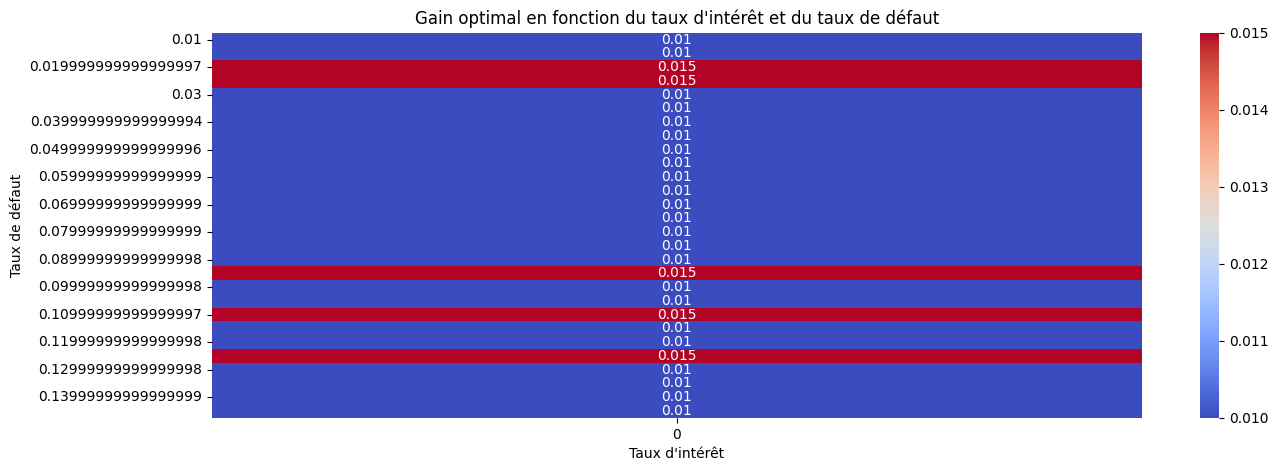

In [22]:
b.plot_matrice_taux_default()
b.plot_optimal_taux_default()

In [23]:
import plotly.graph_objects as go

# Assuming b.matrice_taux_default is a DataFrame
matrice_taux_default = b.matrice_taux_default

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(z=matrice_taux_default.values, x=matrice_taux_default.columns, y=matrice_taux_default.index, colorscale='Viridis')])
fig.update_layout(title='Gain/Perte en fonction du taux d\'intérêt et du taux de défaut pour un pf de 300 emprunteurs', autosize=False, 
                    width=1000, height=800, margin=dict(l=65, r=50, b=65, t=90))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='Taux', yaxis_title='Proba Default', zaxis_title='Gain/Perte (%)'))

# Show the interactive plot
fig.show()

In [191]:
b = Backtest(nb_emprunt=[10, 25, 50],
                montant_a_investir=680,
                date_emprunt="2021-01-01",
                type_investissement="uniforme",
                taux=0.0896,
                proba_defaut=0.04,
                nb_essais=100000)

b.backtest()
b.calculate_results()

In [192]:
b.results

,10,25,50
VaR 95%,-0.018,0.013,0.030
ES 95%,-0.051,-0.004,0.019
VaR 99%,-0.079,-0.016,0.012
ES 99%,-0.108,-0.032,0.002
Mean,0.064,0.064,0.064
Std,0.040,0.025,0.018
Max,0.088,0.088,0.087
Min,-0.288,-0.121,-0.047
Median,0.086,0.070,0.066
Mode,0.086,0.086,0.086


In [28]:
b.compute_matrice_taux_default(bornes_taux=[0.03, 0.12], bornes_defaut=[0.03, 0.12], resolution=0.01)

100%|██████████| 9/9 [01:09<00:00,  7.72s/it]


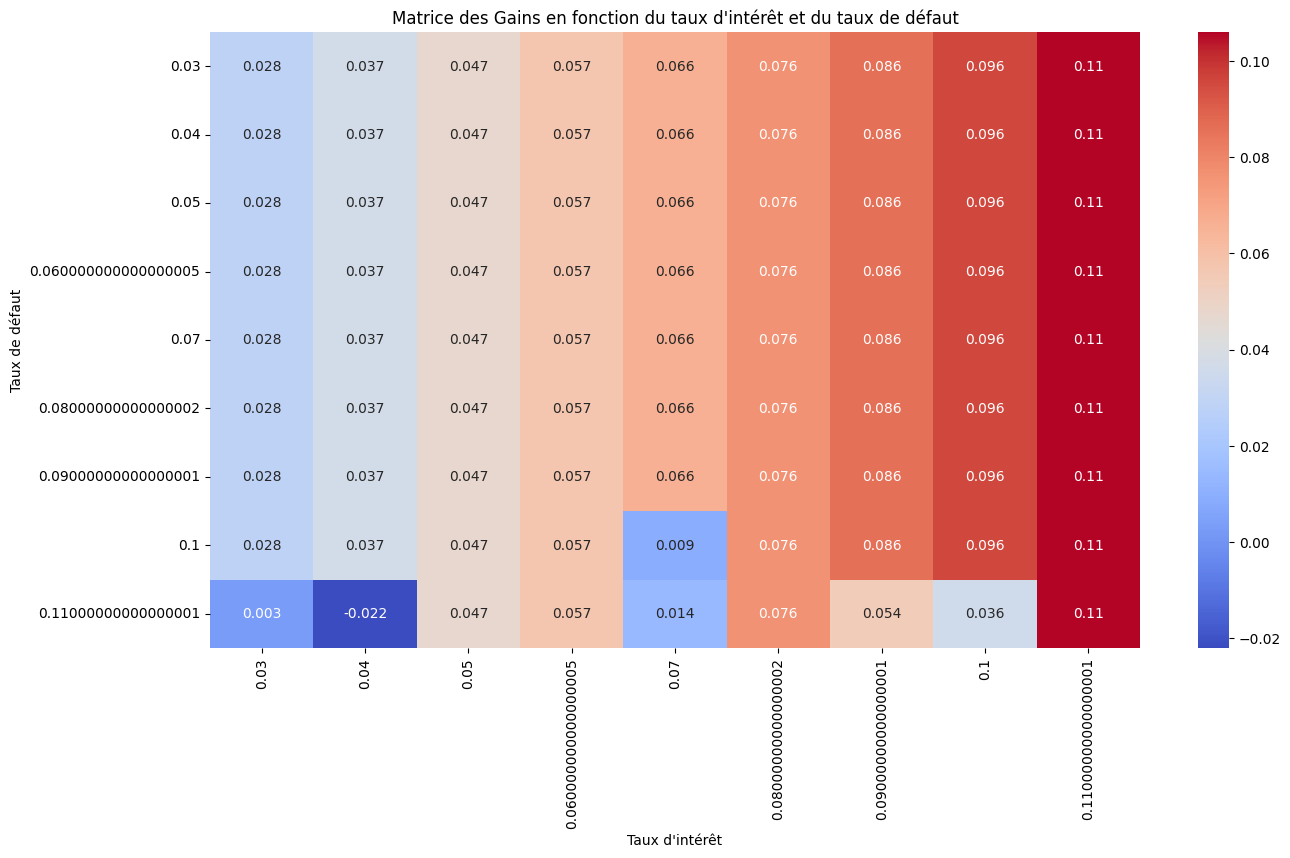

In [30]:
b.plot_matrice_taux_default()

In [66]:
s = Strategy([34], 680, "2023-01-01", 0.01, 0.06)

liste_emprunteurs = []
for _ in range(3):
    taux = 0.095
    montant_restant = 20
    duree_restante = np.random.randint(2, 23)
    defaut = 0.04 / duree_restante
    liste_emprunteurs.append(Emprunteur_agent(taux, montant_restant, duree_restante, defaut, "2023-01-01"))


e1 = Emprunteur_agent(0.09, 20, 12, 0.03, "2023-01-01")
e2 = Emprunteur_agent(0.095, 20, 6, 0.06, "2023-01-01")

liste_emprunteurs = [e1, e2]

p = Portfolio(liste_emprunteurs, 0)
for _ in range(e1.duree_restante):
    p.montant_remboursement_total(e1)
    p.liquidite += e1.mensualite
for _ in range(e2.duree_restante):
    p.montant_remboursement_total(e2)
    p.liquidite += e2.mensualite

p.liquidite/40 * 100

3.8654062922091614

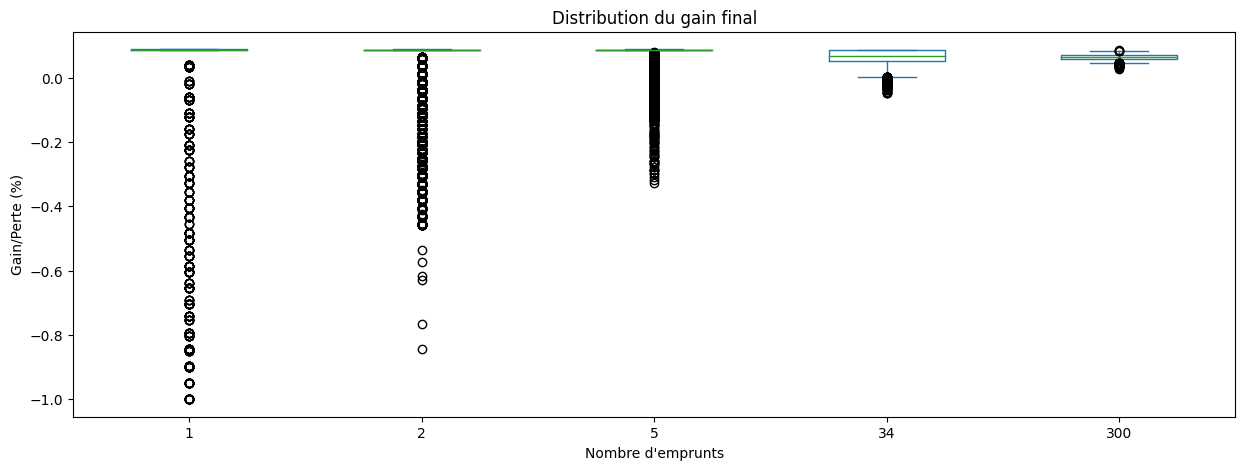

In [24]:
b.final_liquidite.plot(kind='box', figsize=(15, 5), title="Distribution du gain final")
plt.xlabel("Nombre d'emprunts")
plt.ylabel("Gain/Perte (%)")
plt.show()